In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.dates import DateFormatter
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

Importing plotly failed. Interactive plots will not work.


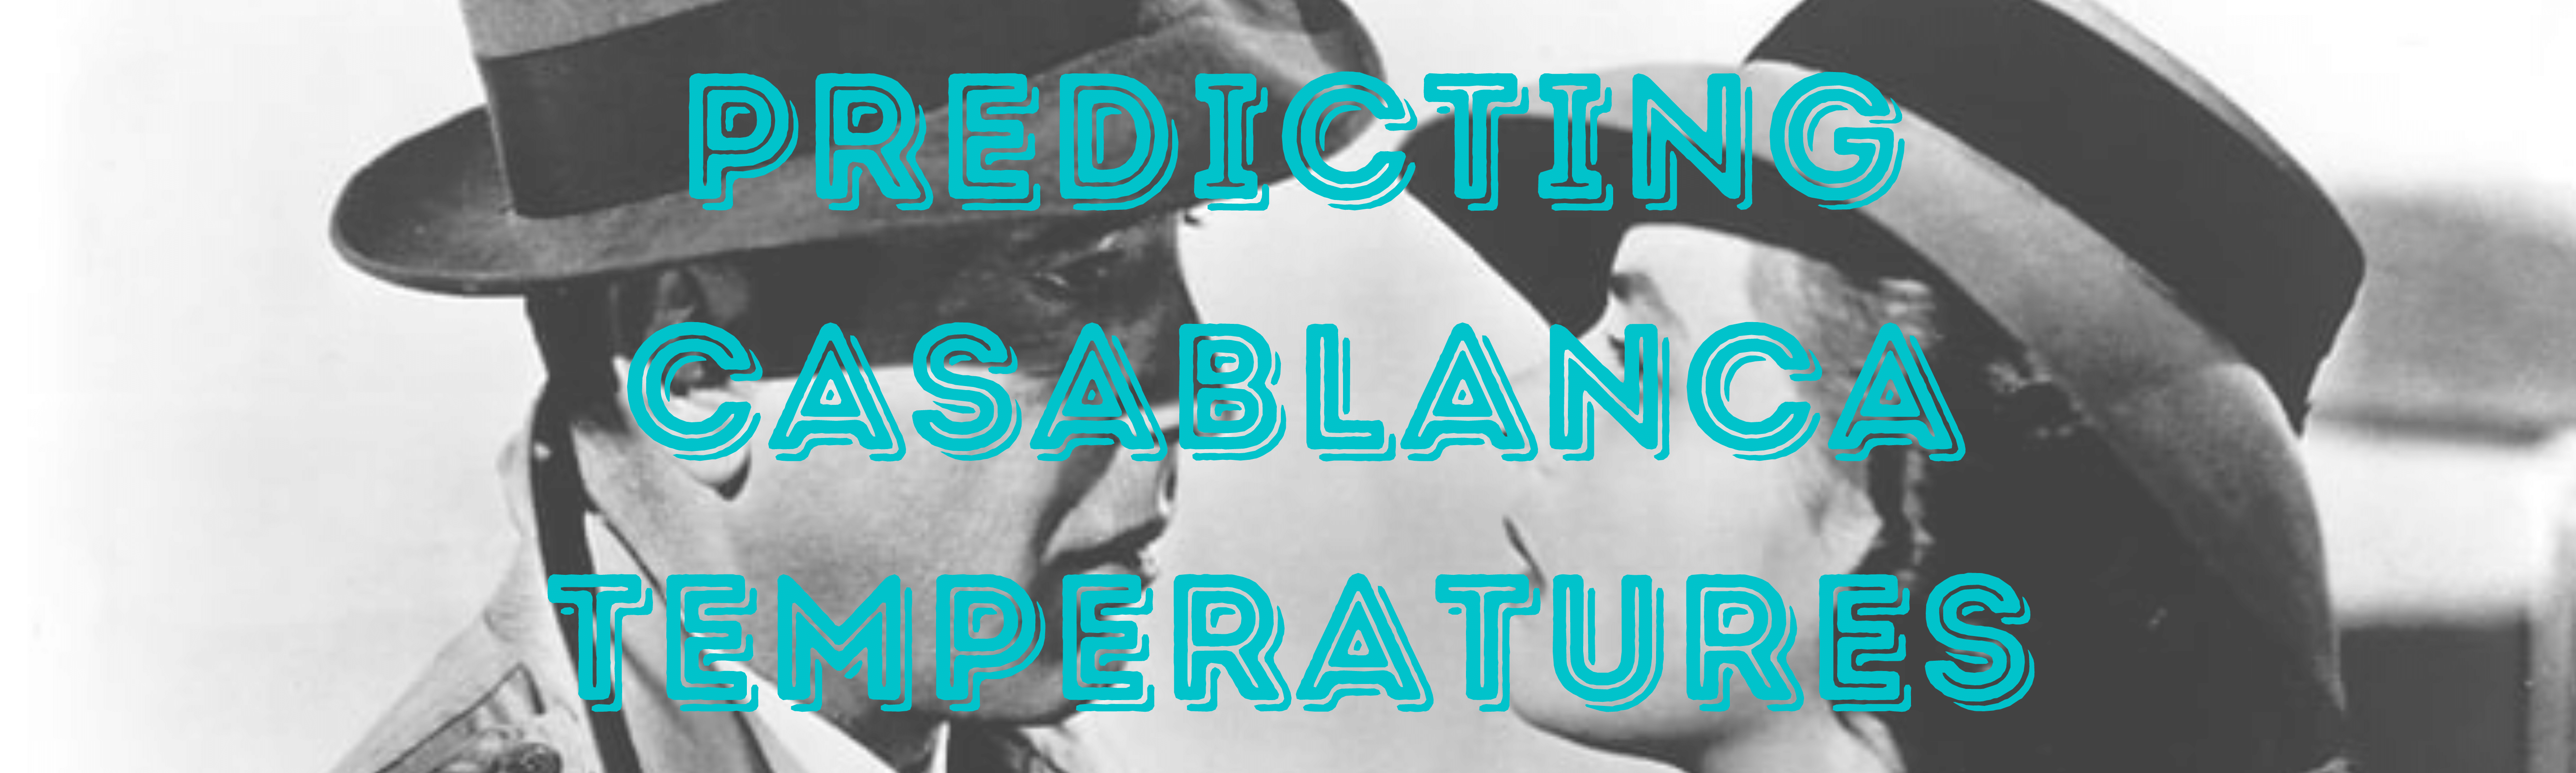

# Project Goals:
- Complete end to end Data Science Pipleline on Casablanca weather data.
- Build a model to predict temperatures for weather in Casablanca
- Complete Exploratory Data Analysis to find insights in data.

# Acquire & Prep

# Import CSV  after Intial Prep in Google Sheets
- Removed all locations except Casablanca, Morocco
- Looked at nulls and decide timeframe to use
- 2013 was incomplete, so I decided to use the timeframe from 1812 to 2012.  There were no nulls in this time period.
- I also dropped the following columns:
    - City
    - Country
    - Latitude
    - Longitude
    - AverageTemperatureUncertainty
- Changed the names of the two remaining columns:
    - dt to date
    - AverageTemperature to average_temperature
- Import CSV & Change date to datetime data type & set as index

In [2]:
df = pd.read_csv('globallandtemperaturescasablanca.csv')
df.head()

date  average_temperature
0  1812-01-01                7.295
1  1812-02-01                9.056
2  1812-03-01               10.175
3  1812-04-01               13.966
4  1812-05-01               15.755

In [3]:
df.shape

(2412, 2)

# 🧹 Time Series Data Prep

In [4]:
# chage date to datetime dtype
df.date = pd.to_datetime(df.date)
# verify above change worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 2412 non-null   datetime64[ns]
 1   average_temperature  2412 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.8 KB


In [5]:
#sort rows by date and set index as date
df = df.set_index("date").sort_index()
# Verify above worked
df.head()

average_temperature
date                           
1812-01-01                7.295
1812-02-01                9.056
1812-03-01               10.175
1812-04-01               13.966
1812-05-01               15.755

# 🕵🏻‍♀️ Exploratory Data Analysis

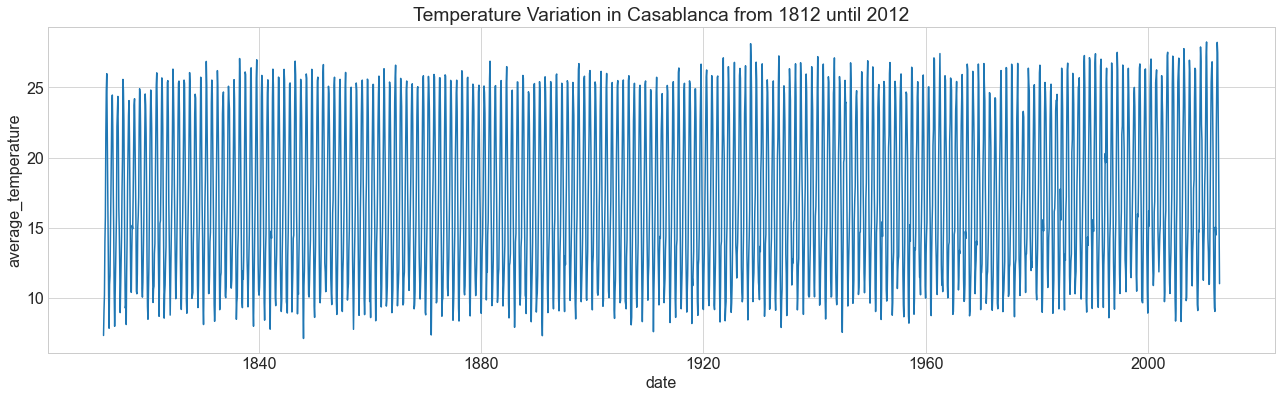

In [6]:
# Take Initial look at the data
plt.figure(figsize=(22,6))
sns.lineplot(x=df.index, y=df['average_temperature'])
plt.title('Temperature Variation in Casablanca from 1812 until 2012')
plt.show()

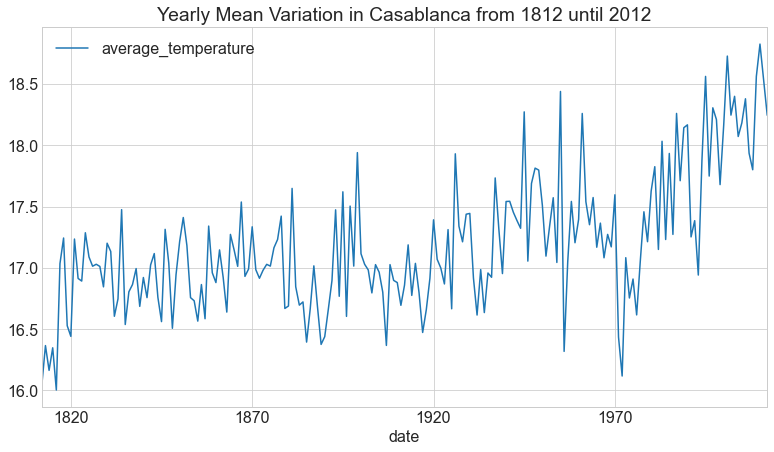

In [7]:
#Take a look at a yearly mean plot
df.resample('Y').mean().plot()
plt.title('Yearly Mean Variation in Casablanca from 1812 until 2012')
plt.show()

# Takeaways:
- looks like the pattern is consistent with an increase in temperatures the closer we get to the end of the data (2012)

# ✂️ Split Data to Do Remaining Exploration on Train
- Plan: Use percentage based split, but adjust to include whole years

In [8]:
#First split based on percentage and look at the end of train and validate to split by year
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [9]:
# Look at tail of train df
# Based on output, train df will end in December of 1912
train.tail(1)

average_temperature
date                           
1912-06-01               22.011

In [10]:
#repeat above with validate
#validate will end in December 1972 and test will be the rest of the data set
validate.tail(1)

average_temperature
date                           
1972-09-01               20.978

### ✂️ Split Manually based on years above

In [11]:
train = df.loc[:'1912']
validate = df.loc['1913':'1972']
test = df.loc['1973':]

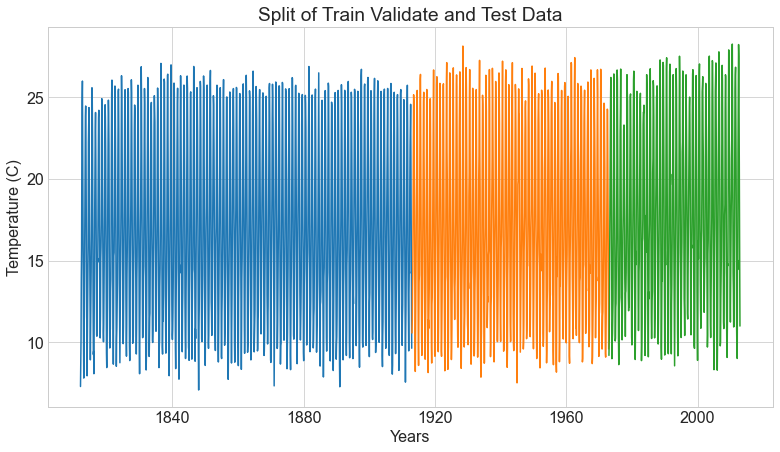

In [12]:
# Visualize the split
plt.plot(train.index, train.average_temperature)
plt.plot(validate.index, validate.average_temperature)
plt.plot(test.index, test.average_temperature)
plt.title('Split of Train Validate and Test Data')
plt.xlabel('Years')
plt.ylabel('Temperature (C)')
plt.show()

# 🕵🏻‍♀️ Explore on Train

In [13]:
# Store target variable as y
y = train.average_temperature

<AxesSubplot:ylabel='Frequency'>

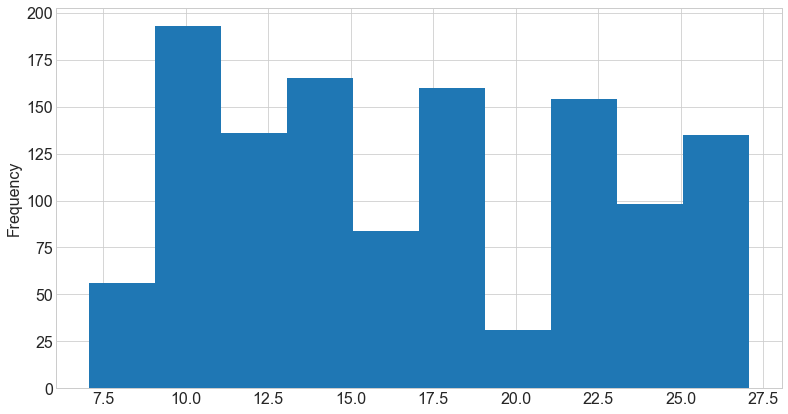

In [14]:
y.plot.hist()

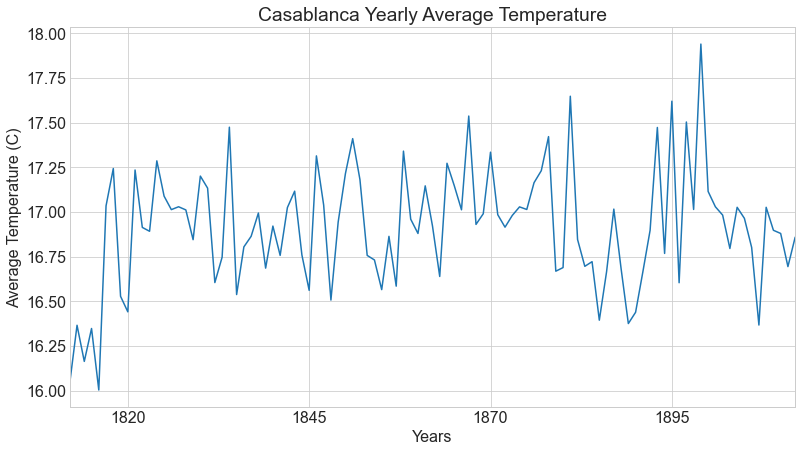

In [15]:
y.resample('Y').mean().plot(title='Casablanca Yearly Average Temperature')
plt.xlabel('Years')
plt.ylabel('Average Temperature (C)')
plt.show()

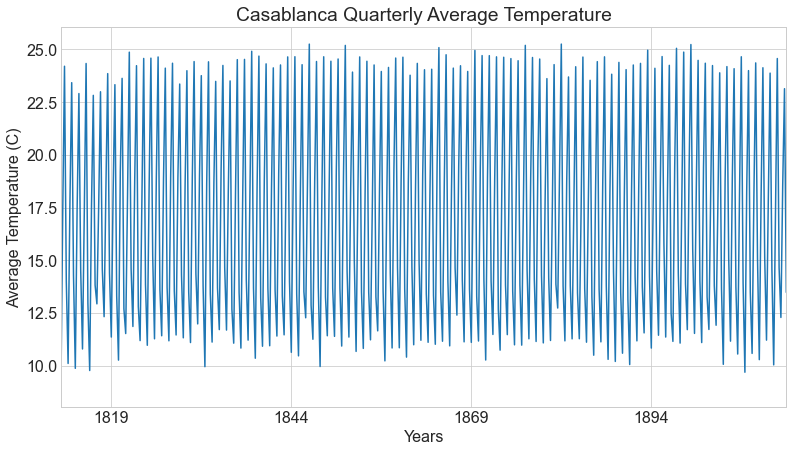

In [16]:
# Look at target over time by quarter
y.resample('Q').mean().plot(title='Casablanca Quarterly Average Temperature')
plt.xlabel('Years')
plt.ylabel('Average Temperature (C)')
plt.show()

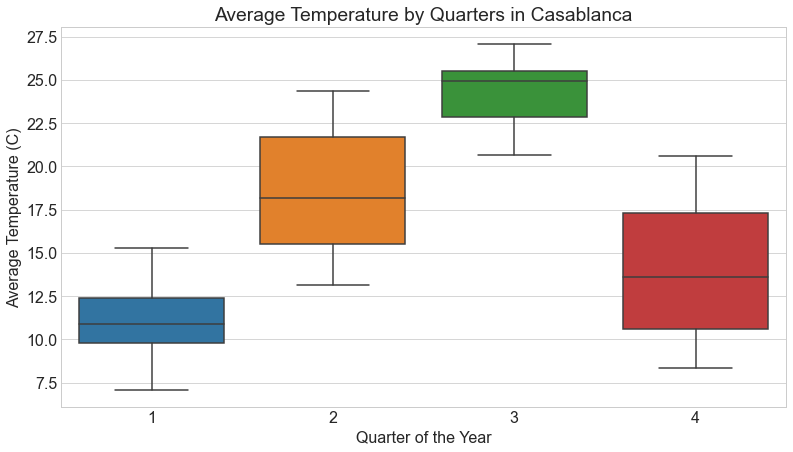

In [17]:
sns.boxplot(data = train, x = train.index.quarter, y = 'average_temperature')
plt.ylabel('Average Temperature (C)')
plt.xlabel('Quarter of the Year')
plt.title('Average Temperature by Quarters in Casablanca')
plt.show()

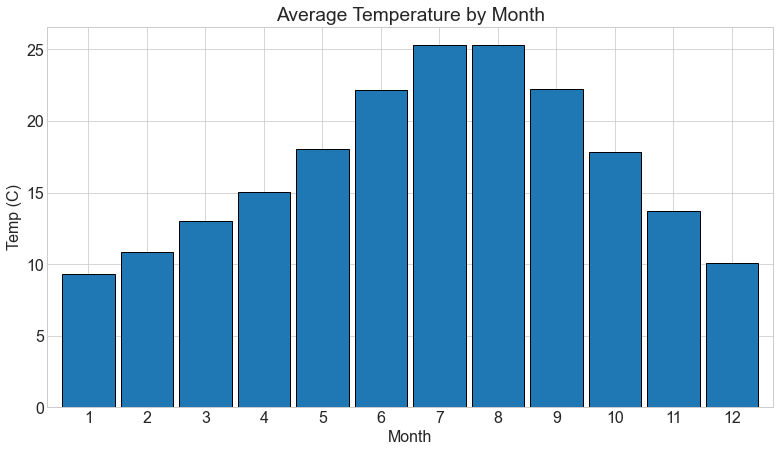

In [18]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (C)')
plt.show()

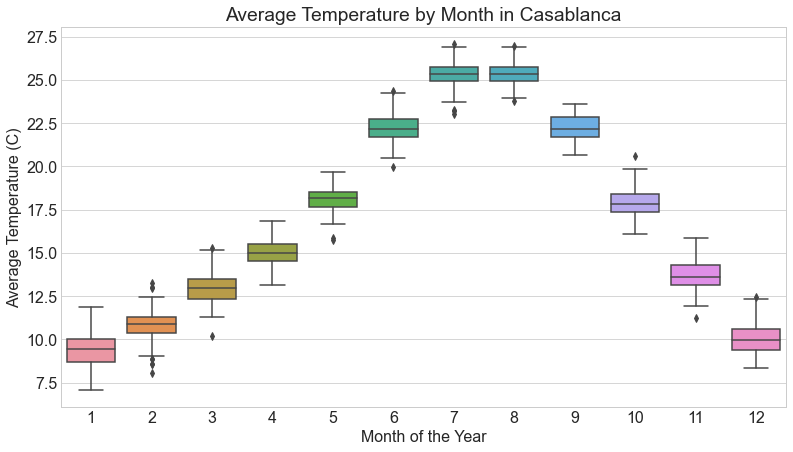

In [19]:
sns.boxplot(data = train, x = train.index.month, y = 'average_temperature')
plt.ylabel('Average Temperature (C)')
plt.xlabel('Month of the Year')
plt.title('Average Temperature by Month in Casablanca')
plt.show()

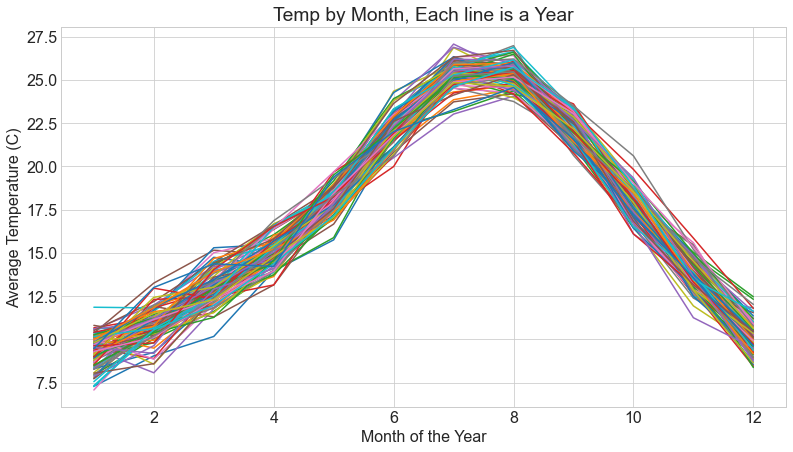

In [20]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(legend = False)
plt.title('Temp by Month, Each line is a Year')
plt.ylabel('Average Temperature (C)')
plt.xlabel('Month of the Year')
plt.show()

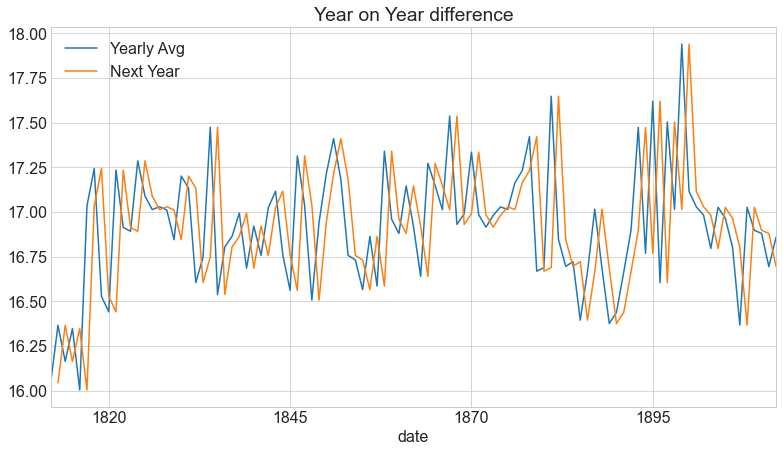

In [21]:
ax = y.resample('Y').mean().plot(label='Yearly Avg')
y.resample('Y').mean().shift(1).plot(label='Next Year', ax=ax)
ax.legend()
plt.title('Year on Year difference')
plt.show()

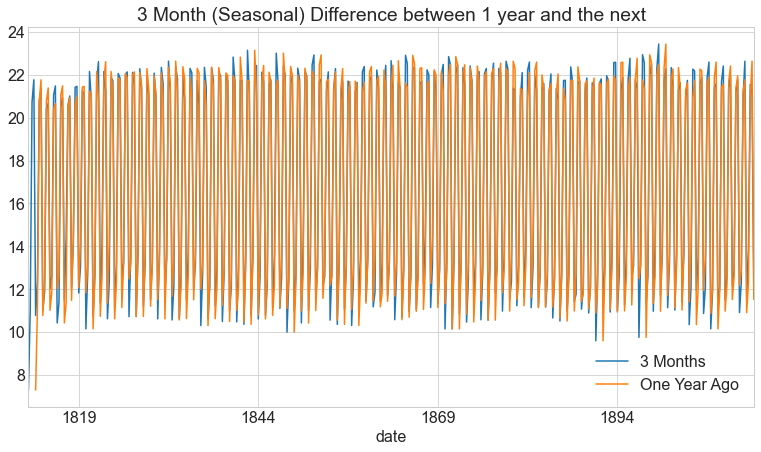

In [22]:
ax = y.resample('3M').mean().plot(label='3 Months')
y.resample('3M').mean().shift(4).plot(label='One Year Ago', ax=ax)
ax.legend()
plt.title('3 Month (Seasonal) Difference between 1 year and the next')
plt.show()

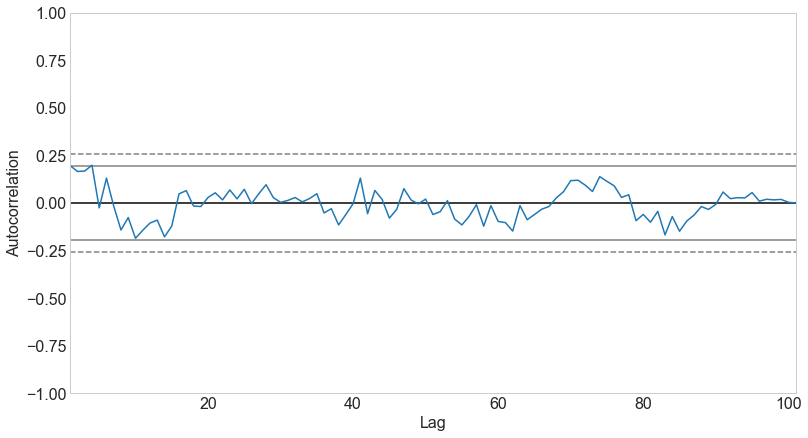

In [23]:
# autocorrelation plot 1 Y resample
pd.plotting.autocorrelation_plot(y.resample('Y').mean())
None

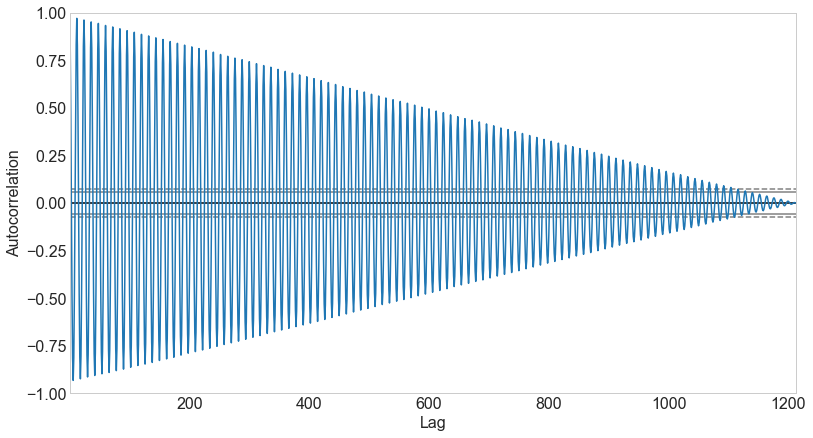

In [24]:
# autocorrelation Monthly
pd.plotting.autocorrelation_plot(y)
None

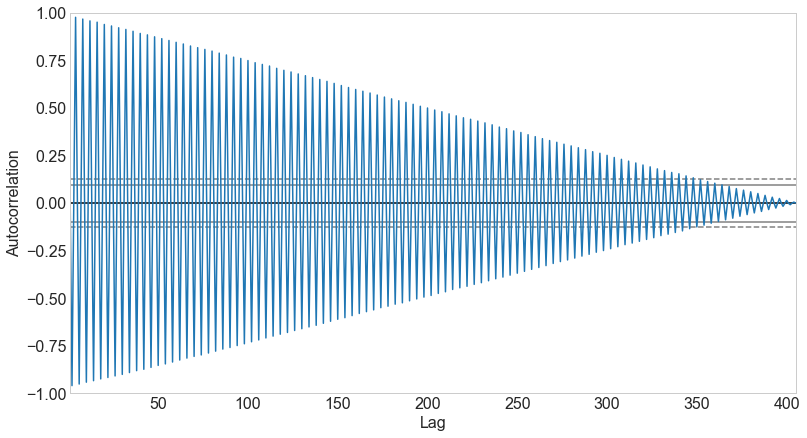

In [25]:
# autocorelation 3 months
pd.plotting.autocorrelation_plot(y.resample('3M').mean())
None

# Explore Takeaways:
- Month to month temperatures follow a traditional pattern of the sesons.
- This pattern can be seen more clearly when looking at quarteryly box plots.  The seasons are distinctive and as expected.
- The three month seasonal difference chart shows a good correlation and will be used when modeling below the pattern seems more correlated than the year over year.

# Model

# 🔌 Create Helper Functions

In [26]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 2)
    return rmse

In [27]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [28]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [99]:
def rmse_value(predictions, actuals):
    '''
    This function takes in predictions and actuals and returns the rmse
    '''
    rmse = mean_squared_error(predictions, actuals, squared = False)
    return rmse

In [29]:
eval_df

Empty DataFrame
Columns: [model_type, target_var, rmse]
Index: []

## Simple Average

In [30]:
temperature = round(train['average_temperature'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'average_temperature': [temperature]}, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [31]:
yhat_df.head()

average_temperature
date                           
1913-01-01                16.92
1913-02-01                16.92
1913-03-01                16.92
1913-04-01                16.92
1913-05-01                16.92

average_temperature -- RMSE: 6


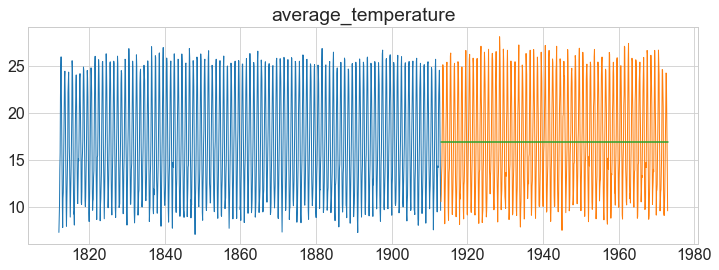

In [32]:
for col in train.columns:
    plot_and_eval(col)

In [33]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [34]:
eval_df

model_type           target_var  rmse
0  simple_average  average_temperature  5.69

# Moving Average - 3 Month

In [35]:
# compute a 3 month rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 3

temperature = round(train['average_temperature'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

average_temperature
date                           
1913-01-01                13.47
1913-02-01                13.47
1913-03-01                13.47

average_temperature -- RMSE: 7


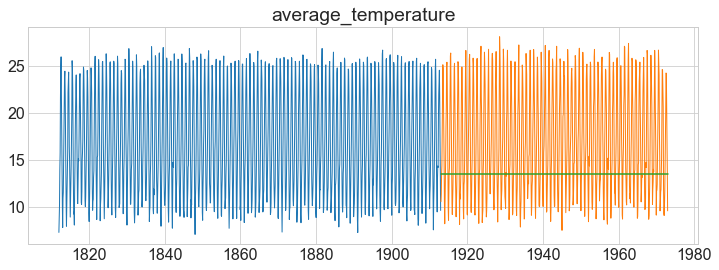

In [36]:
#Plot actual vs Predicted Values
for col in train.columns:
    plot_and_eval(col)

## Evaluate Moving Average

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3m moving average', 
                             target_var = col)

In [38]:
eval_df

model_type           target_var  rmse
0     simple_average  average_temperature  5.69
1  3m moving average  average_temperature  6.82

# Previous Cycle Model

In [39]:
validate_predictions = validate + train.diff(3).mean()

In [40]:
v_df = validate_predictions.values.flatten()

In [89]:
# set yhat_df to index of validate
yhat_df = pd.DataFrame({'average_temperature':v_df},
                               index = validate.index)

In [90]:
yhat_df

average_temperature
date                           
1913-01-01            10.581495
1913-02-01            11.379495
1913-03-01            13.396495
1913-04-01            14.409495
1913-05-01            18.237495
...                         ...
1972-08-01            24.211495
1972-09-01            20.989495
1972-10-01            18.379495
1972-11-01            13.896495
1972-12-01             9.605495

[720 rows x 1 columns]

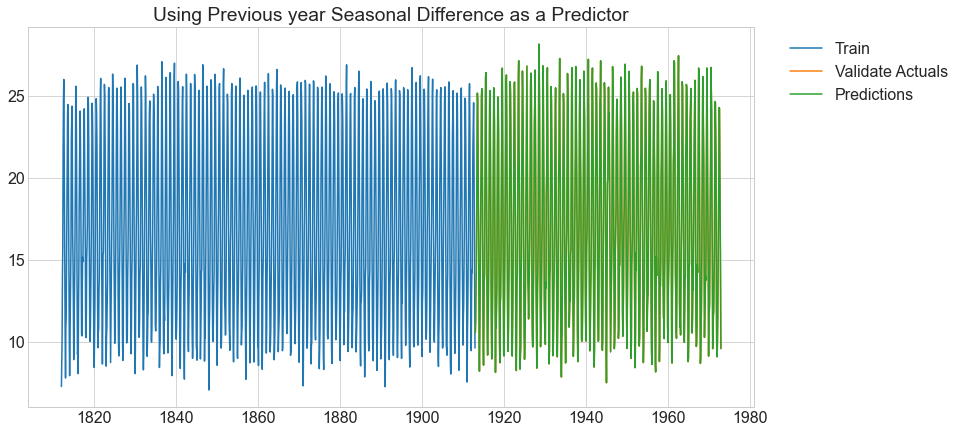

In [91]:
plt.plot(train, label = 'Train')
plt.plot(validate['average_temperature'], label = 'Validate Actuals')
plt.plot(yhat_df['average_temperature'], label = 'Predictions')
plt.title('Using Previous year Seasonal Difference as a Predictor')
plt.legend(bbox_to_anchor = (1.03, 1))
plt.show()

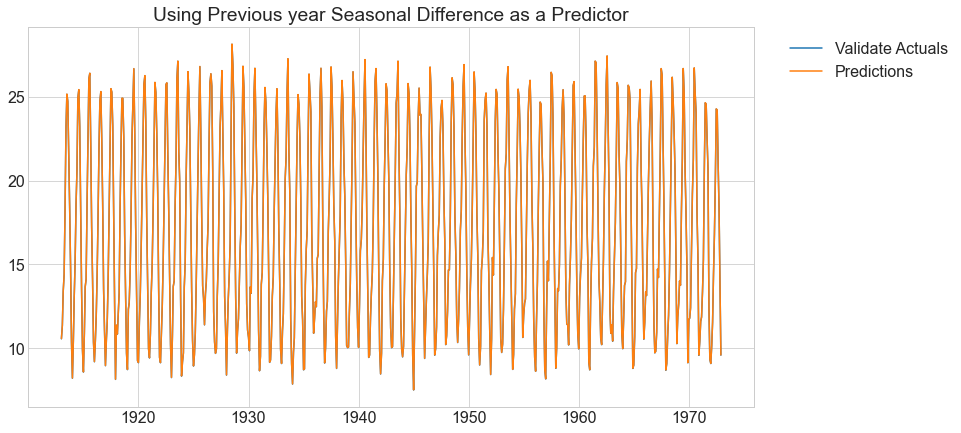

In [92]:
plt.plot(validate['average_temperature'], label = 'Validate Actuals')
plt.plot(yhat_df['average_temperature'], label = 'Predictions')
plt.title('Using Previous year Seasonal Difference as a Predictor')
plt.legend(bbox_to_anchor = (1.03, 1))
plt.show()

In [93]:
for col in train.columns:
    eval_df = append_eval_df(model_type='Previous Cycle', 
                             target_var = col)

In [94]:
eval_df

model_type           target_var  rmse
0     simple_average  average_temperature  5.69
1  3m moving average  average_temperature  6.82
2     Previous Cycle  average_temperature  0.01
3     Previous Cycle  average_temperature  0.01

# Evaluate Models

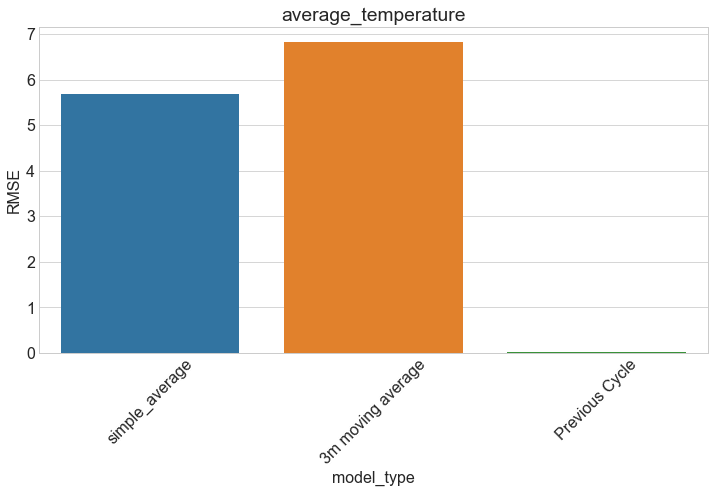

In [61]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

# Run Test on Previous Cycle Model - 3 Month Season

In [78]:
test_predictions = test + train.diff(3).mean()

In [79]:
t_df = test_predictions.values.flatten()

In [95]:
# set yhat_df to index of validate
yhat_df = pd.DataFrame({'average_temperature':t_df},
                               index = test.index)

In [96]:
yhat_df

average_temperature
date                           
1973-01-01             9.210495
1973-02-01            10.220495
1973-03-01            12.995495
1973-04-01            15.507495
1973-05-01            19.178495
...                         ...
2012-08-01            27.498495
2012-09-01            23.700495
2012-10-01            19.578495
2012-11-01            14.832495
2012-12-01            11.006495

[480 rows x 1 columns]

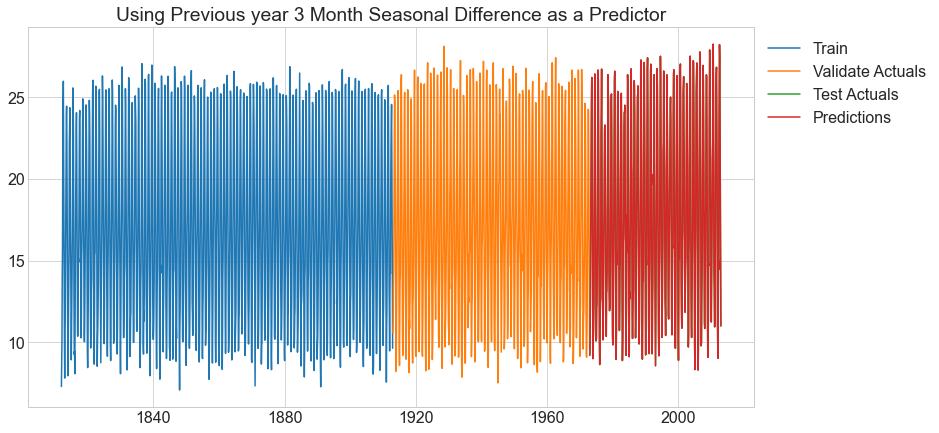

In [98]:
plt.plot(train, label = 'Train')
plt.plot(validate['average_temperature'], label = 'Validate Actuals')
plt.plot(test['average_temperature'], label = 'Test Actuals')
plt.plot(yhat_df['average_temperature'], label = 'Predictions')
plt.title('Using Previous year 3 Month Seasonal Difference as a Predictor')
plt.legend(bbox_to_anchor = (1, 1))
plt.show()

In [102]:
# RMSE for Test based on 3 month seasonal difference
seasonal_difference_rmse = round(rmse_value(test['average_temperature'], yhat_df['average_temperature']),2)
seasonal_difference_rmse

0.01

# Conclusions:

- The 3 month previous cycle model preformed the best with a very low RMSE of .01.
- With more time I would like to run a SARIMA and Prophet Model on the data to see how they preform.  
- I'd also like to look at a smaller slice of the data and compare thre predictions past the data to the actuals that have been measured since this data set was released.